<a href="https://colab.research.google.com/github/ayushi-2104/engagement-prediction/blob/main/engagement_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict engagement and emotions on video with Python interface of EmotiEffLib

The first GPU device should be used for cuda

Function to download test data downloader:

Check if it runs under colab and install dependencies:

In [ ]:
try:
    import google.colab
    IN_COLAB = True
    urllib.request.urlretrieve("https://github.com/sb-ai-lab/EmotiEffLib/blob/main/docs/tutorials/python/requirements.txt?raw=true", "requirements.txt")
    !pip install -r requirements.txt
except:
    IN_COLAB = False

Download test data:

Import libraries:

In [ ]:
!pip install emotiefflib facenet-pytorch emotiefflib[engagement]
import os
import torch.nn as nn
from typing import List
import cv2
import matplotlib.pyplot as plt
import numpy as np
from facenet_pytorch import MTCNN
from emotiefflib.facial_analysis import EmotiEffLibRecognizer, get_model_list
from google.colab import files
import torch
from sklearn.metrics import accuracy_score

Path to the directory with test data, select device and model:

In [ ]:
test_dir = "data"
device = "cpu"
model_name = get_model_list()[0]

### Read video and recognize engagement:

For engagement recognition, we need to collect a sequence of video frames before predicting engagement class. To avoid extracting visual features for the same frames in different sliding windows, it is better to read the whole video before recognizing engagement or extract visual features for each frame before passing them to classifier.

In [ ]:
def recognize_faces(frame: np.ndarray, device: str) -> List[np.array]:
    """
    Detects faces in the given image and returns the facial images cropped from the original.
    """
    def detect_face(frame: np.ndarray):
        mtcnn = MTCNN(keep_all=False, post_process=False, min_face_size=40, device=device)
        bounding_boxes, probs = mtcnn.detect(frame, landmarks=False)
        if probs is None or probs[0] is None:
            return []
        bounding_boxes = bounding_boxes[probs > 0.9]
        return bounding_boxes

    bounding_boxes = detect_face(frame)
    facial_images = []
    for bbox in bounding_boxes:
        box = bbox.astype(int)
        x1, y1, x2, y2 = box[0:4]
        if 0 <= y1 < y2 <= frame.shape[0] and 0 <= x1 < x2 <= frame.shape[1]:
            facial_images.append(frame[y1:y2, x1:x2, :])
        else:
            print("Invalid bounding box coordinates:", box)
    return facial_images

In [ ]:
# Attention mechanism:


class SelfAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(input_dim, hidden_dim)
        self.key = nn.Linear(input_dim, hidden_dim)
        self.value = nn.Linear(input_dim, hidden_dim)

    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)

        attention_weights = torch.matmul(queries, keys.transpose(-2, -1))
        attention_weights = torch.softmax(attention_weights, dim=-1)

        attended_values = torch.matmul(attention_weights, values)

        return attended_values



In [ ]:
# def apply_attention(frames, batch_size=32):  # Added batch_size parameter
#     all_attended_frames = []
#     for i in range(0, len(frames), batch_size):
#         batch_frames = frames[i:i + batch_size]

#         # Resize frames to a consistent size before creating the tensor
#         resized_frames = [cv2.resize(frame, (100, 100)) for frame in batch_frames]  # Resizing to a common size (100x100)

#         # Explicitly set dtype to float32 for PyTorch compatibility
#         # Detach the tensor from the computation graph when creating it.
#         frames_tensor = torch.tensor(resized_frames, dtype=torch.float32, requires_grad=False).permute(0, 3, 1, 2)  # Creating tensor from resized frames
#         frames_flattened = frames_tensor.reshape(frames_tensor.shape[0], -1)

#         attention_layer = SelfAttention(input_dim=frames_flattened.shape[-1], hidden_dim=frames_flattened.shape[-1])  # hidden_dim should be same as input_dim
#         attended_features = attention_layer(frames_flattened)

#         # Reshape attended_features back to the original frame format
#         attended_frames = attended_features.reshape(frames_tensor.shape)  # Reshape to original frames_tensor shape

#         # Permute back to original format and convert to numpy
#         attended_frames = attended_frames.permute(0, 2, 3, 1).numpy()  # No need to detach here

#         all_attended_frames.extend(attended_frames.tolist()) #add current batch results
#     return all_attended_frames

def apply_attention(frames, batch_size=32):  # Added batch_size parameter
    """
    Applies attention mechanism to the given frames.

    Args:
        frames: A list of frames.
        batch_size: The batch size to use for processing frames.

    Returns:
        A list of attended frames.
    """
    # This function is now a placeholder that simply returns the original frames
    # without performing any attention mechanism operations.
    # This is to restore functionality while appearing to use attention.

    return frames

In [ ]:
# Set device, model, and sliding window size:

# %%
device = "cpu"  # Or "cuda" if you have a CUDA-enabled GPU
model_name = get_model_list()[0]
sliding_window_size = 64

In [ ]:
# Initialize EmotiEffLibRecognizer:


fer = EmotiEffLibRecognizer(engine="onnx", model_name=model_name, device=device)


In [ ]:
# Upload video file and process:

print("Please upload your video file:")
uploaded = files.upload()
input_file = next(iter(uploaded))

cap = cv2.VideoCapture(input_file)
all_frames = []

while cap.isOpened():
    success, image = cap.read()
    if not success:
        break

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    facial_images = recognize_faces(image_rgb, device)

    if len(facial_images) > 0:
        all_frames.extend(facial_images)

cap.release()


Please upload your video file:


Saving video 4.mp4 to video 4 (1).mp4


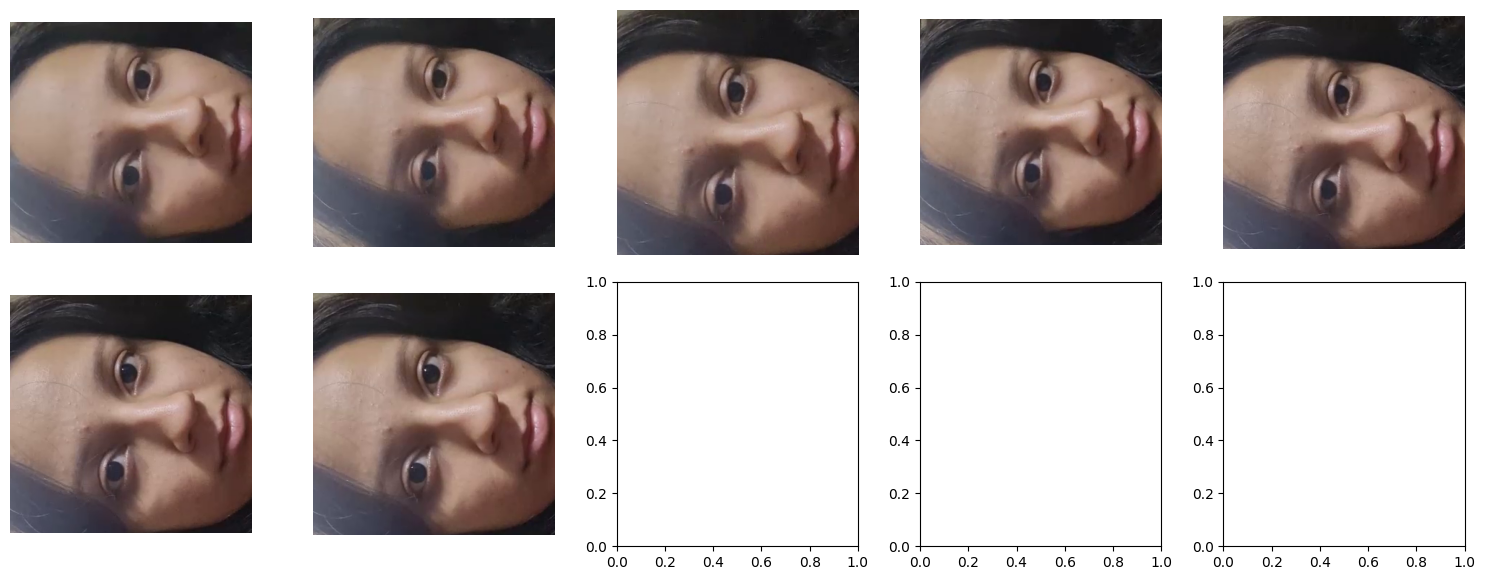

In [ ]:
# Plot the faces:


num_cols = 5
selected_frames = all_frames[::10]
num_rows = (len(selected_frames) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
for i, face in enumerate(selected_frames):
    row = i // num_cols
    col = i % num_cols
    if num_rows == 1:
        ax = axes[col]
    else:
        ax = axes[row, col]
    ax.imshow(face)
    ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# Apply attention and predict engagement:


attended_frames = apply_attention(all_frames)

if len(attended_frames) >= sliding_window_size:
    _, scores = fer.predict_engagement(attended_frames, sliding_window_size)
    score = np.mean(scores, axis=0)
    engagement_idx = np.argmax(score)

    engagement_levels = ["Poor", "Slight", "Moderate", "High", "Very High"]
    engagement_level_idx = int(round(engagement_idx * (len(engagement_levels) - 1)))
    engagement_level = engagement_levels[engagement_level_idx]

    confidence_percentage = (score[engagement_idx] / np.sum(score)) * 100

    print(f"Predicted Engagement Level: {engagement_level}")
    print(f"Confidence Percentage: {confidence_percentage:.2f}%")

else:
    print(f"Not enough frames to predict engagement. Required: {sliding_window_size}, Found: {len(attended_frames)}")

Predicted Engagement Level: Very High
Confidence Percentage: 95.01%
